### Restoration of experimental nanoparticles dataset from a pretrained restoration model

*This notebook presents the restoration of experimental data using a model pretrained on a simulated dataset. The data consist of a 2D sinogram taken from the 3D acquisition of platinum nanoparticles. It was acquired between +/-60° with & 2° tilt angle. The sinogram is also manually degraded to perform the restoration on more challenging scenarios :*
- -60°:2°:+60°
- -60°:10°:+60°
- -30°:2°:+30°

*The Model was trained for the restoration of the reconstructions of the simulated nanoparticles. The model is applied on a 2D SIRT reconstruction at a time.*

In [6]:
import sys
sys.path.insert(0, '../../Src')
from model import model_unet
from radon import Radon2D
from utils import simplify, normalize

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import torch
from einops import rearrange

dtype = torch.cuda.FloatTensor
plt.rcParams['image.cmap'] = 'gray'

#### Load the experimental data

The sinograms of interest are stored in *Data/Experimental* and corresponding angular range are placed in *Data/Angles*.
The acquisition scenario can be selected (1, 2 or 3) with **ACQUISITION_CASE**.
The SIRT reconstruction of the chosen sinogram is then computed.

In [11]:
# 1, 2 or 3 corresponding to acquisition range -60:2:+60, -60:10:+60 and -30:2:+30 respectively
ACQUISITION_CASE = 3

with open(f'../../Data/Angles/angles_{ACQUISITION_CASE}.txt') as file:
    ANGLE = np.array([int(line.strip()) for line in file])

degraded_sinogram = imread(f'../../Data/Experimental/experimental_{ACQUISITION_CASE}.tif')
degraded_sinogram = torch.from_numpy(degraded_sinogram).type(dtype)

IMG_SIZE = degraded_sinogram.shape[1]

radon_op = Radon2D(angle=np.deg2rad(ANGLE), size=IMG_SIZE)
sirt_reco = radon_op.backward_sirt_ts(degraded_sinogram)
sirt_reco = normalize(sirt_reco)

#### Load and apply the trained network to the SIRT degraed reconstruction

*The network is setup with the same parameter than for the simulated data restoration and the pretrained weights from the same **ACQUISITION_CASE** are loaded.*
*The model is then applied to th 2D sinogram of interest.*

In [12]:
ud_filters, skip_filters = [32,64,128], [8,16,32]
n_scale = len(ud_filters)
model = model_unet(input_shape=1,
            down_filters=ud_filters, up_filters=ud_filters, skip_filters=skip_filters,
            down_kernels=[3]*len(ud_filters), up_kernels=[3]*len(ud_filters), skip_kernels=[1]*len(ud_filters),
            up_mode='bilinear', down_mode='stride', pad_mode='reflect'
           ).to('cuda').type(dtype)

model.load_state_dict(torch.load(f"../../Trained_models/model_trained_{ACQUISITION_CASE}.pth"))

/tmp/ipykernel_3049020/2672974689.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"../../Trained_models/model_trained_{ACQUISITION_CASE

<All keys matched successfully>

In [13]:
# Application of the pretrained model
net_input = rearrange(sirt_reco, '1 x y -> 1 1 x y')
out_model = model(net_input)

Text(0.5, 1.0, 'U-Net restoration from SIRT')

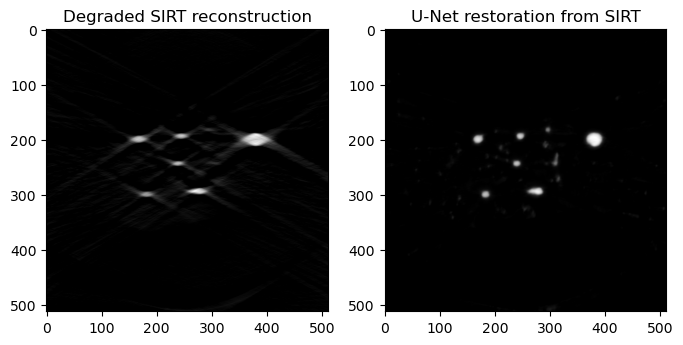

In [14]:
fig, ((ax0, ax1)) = plt.subplots(1, 2, figsize = (8,5))
ax0.imshow(simplify(sirt_reco))
ax0.set_title('Degraded SIRT reconstruction')
ax1.imshow(simplify(out_model))
ax1.set_title('U-Net restoration from SIRT')